## Forecasting the Number of Cases of Syphilis for the Remaining Months of Year 2024 in the city of Toronto ##



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

### Extracting all the data for Syphilis and saving it as a new dataframe ###

In [2]:
data = pd.read_csv('Communicable disease surveillance data 2017-2024.csv')

In [3]:
s_data = data[data['Disease'].str.strip() == 'Syphilis, infectious']

In [4]:
s_data

,Disease,YTD Cases,January,February,March,April,May,June,July,August,September,October,November,December,Year,MOT
10,"Syphilis, infectious","1,312",122,113,145,96,101,131,131,109,102,90,102,70,2023,Sexually Transmitted and Bloodborne
84,"Syphilis, infectious",319,118,105,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,Sexually Transmitted and Bloodborne
158,"Syphilis, infectious","1,244",131,112,106,60,71,77,86,108,130,116,140,107,2020,Sexually Transmitted and Bloodborne
228,"Syphilis, infectious","1,302",132,107,130,120,91,99,126,94,117,123,93,70,2019,Sexually Transmitted and Bloodborne
297,"Syphilis, infectious","1,091",88,76,100,92,106,87,100,99,95,91,84,73,2018,Sexually Transmitted and Bloodborne
368,"Syphilis, infectious",928,95,85,76,75,74,69,96,92,74,70,82,40,2017,Sexually Transmitted and Bloodborne
435,"Syphilis, infectious","1,423",131,114,118,105,101,115,88,112,144,126,146,123,2021,Sexually Transmitted and Bloodborne
505,"Syphilis, infectious","1,724",130,128,141,144,136,137,156,167,138,137,172,138,2022,Sexually Transmitted and Bloodborne


### Data Cleaning, Preparation, Wrangling, and Manipulation ###

In [5]:
s_data.isnull().sum()

Disease      0
YTD Cases    0
January      0
February     0
March        0
April        1
May          1
June         1
July         1
August       1
September    1
October      1
November     1
December     1
Year         0
MOT          0
dtype: int64

In [6]:
s_data.fillna(0, inplace=True)

### Melting the original dataframe. This process creates two new columns: Month (containing the months of the year) and Cases (containing the number of recorded cases) which will help us to convert this data frame into a time series dataframe.

In [7]:
s_data_melted = s_data.melt(
    id_vars=['Year', 'Disease', 'YTD Cases', 'MOT'],
    value_vars=['January', 'February', 'March', 'April',
                'May', 'June', 'July', 'August',
                'September', 'October', 'November', 'December'],
    var_name='Month',
    value_name='Cases'
)

In [8]:
s_data_melted['Cases'] = s_data_melted['Cases'].astype(str).str.replace(',', '').astype(float)


### We will add a new column Date by converting the Year and Month columns into a single column with a datetime datatype using pd.to_datetime. This conversion is achieved by combining the Year and Month columns into a string format and then parsing it as a date.

In [9]:
s_data_melted['Date'] = pd.to_datetime(s_data_melted['Year'].astype(str) + '-' + s_data_melted['Month'], format='%Y-%B')


### Sorting the values of data so we can see the time-series clearly

In [10]:
s_data_melted = s_data_melted.sort_values('Date')


### Extracting Date and Cases columns from the dataframe and saving it to new dataframe. Now we have a time-series dataframe which is ready for analysis and forecasting

In [11]:
s_time_series = s_data_melted[['Date', 'Cases']].set_index('Date').asfreq('MS')


### We need to drop the data after March 2024 because these entries only contain 0 values. This is because our dataset only includes cases from January 2017 to March 2024.

In [12]:
s_time_series = s_time_series[s_time_series.index < '2024-04-01']


### Now, we will perform decomposition on the time series because it helps us isolate and analyze the underlying components such as trend, seasonality, and residuals. This process enhances our understanding of the data's structure and improves our ability to capture the time-series patterns, leading to more accurate forecasting models. By decomposing the time series, we can ensure that our model effectively captures and utilizes the inherent characteristics of the data.

In [13]:
decomposition_s = seasonal_decompose(s_time_series.dropna(), model='additive', period=12)


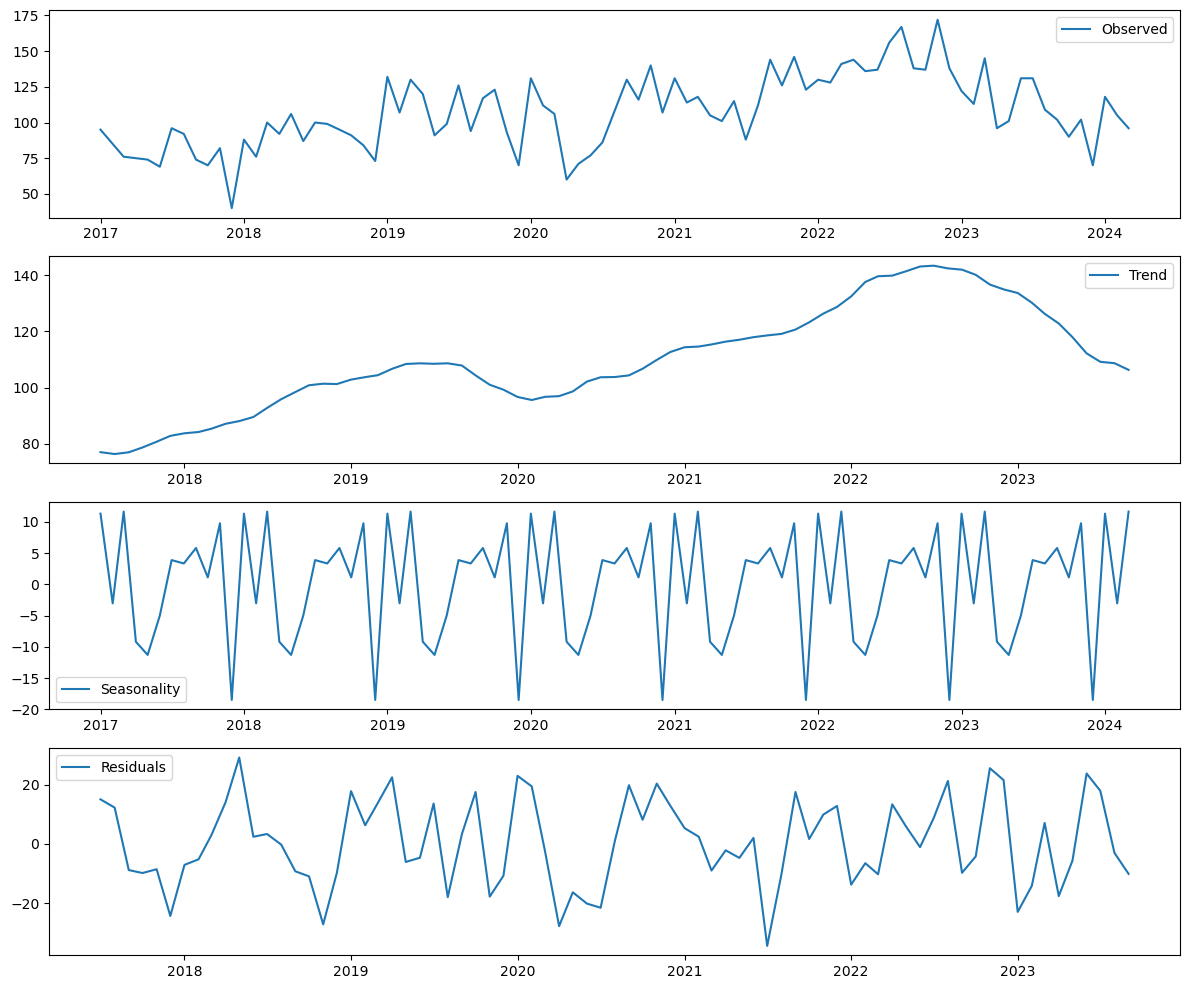

In [14]:
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(decomposition_s.observed, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition_s.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition_s.seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition_s.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### The decomposition of the time series shows that the observed data exhibits a clear trend, seasonality, and residuals. The trend component reveals a significant drop around 2020, followed by a partial recovery and another decline in late 2023. The seasonal component highlights a repeating pattern, indicating regular fluctuations throughout the years. The residuals indicate the irregularities and noise present in the data. We need to take note of these analysis so we can pass it as hyperparameters to our models.

#   

### For this project, we will be training our dataframe using three models: Exponential Smoothing, ARIMA, and SARIMA. Now, let's split the data into training and testing sets to evaluate the performance of these three models and determine which model best captures and forecasts the number of cases for this dataframe.

In [15]:
train_end_s = '2023-12-01'
test_start_s = '2024-01-01'

train_data_s = s_time_series[:train_end_s]
test_data_s = s_time_series[test_start_s:]

### We will be performing a grid search to find the best parameters for our ARIMA and SARIMA models. Initially, we used the original ACF and PACF plots to estimate the parameters, but they did not produce the optimal results. To ensure better performance, we systematically explored a range of potential parameter values using a comprehensive grid search. This involved training and evaluating models for each parameter combination to identify the most effective settings for accurate and reliable forecasts.

In [16]:
import itertools
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

best_aic = float("inf")
best_params = None
best_seasonal_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train_data_s,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
        except:
            continue

print(f'Best SARIMA params: {best_params}')
print(f'Best seasonal params: {best_seasonal_params}')

Best SARIMA params: (0, 2, 1)
Best seasonal params: (0, 0, 2, 12)


In [31]:
p = d = q = range(0, 3)
param_grid = list(itertools.product(p, d, q))

best_rmse = float("inf")
best_params = None
results = []

for param in param_grid:
    try:
        model = ARIMA(train_data_s, order=param)
        fit = model.fit()
        forecast = fit.forecast(steps=len(test_data_s))
        forecast = pd.Series(forecast, index=test_data_s.index)
        rmse = mean_squared_error(test_data_s, forecast, squared=False)
        results.append((param, rmse))
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = param
            
    except Exception as e:
        print(f"Failed for parameters: {param}")
        print(str(e))
        continue

print("Best RMSE: ", best_rmse)
print("Best Parameters: ", best_params)

Best RMSE:  9.096982487151694
Best Parameters:  (0, 0, 0)


### Take note that the hyperparemetes that we are passing to the models are from the insights that we gained earlier in our decomposition and grid search.

In [18]:
exp_smoothing_model_s = ExponentialSmoothing(train_data_s, trend='mul', seasonal='add', seasonal_periods=24)
exp_smoothing_fit_s = exp_smoothing_model_s.fit()

In [19]:
test_forecast_exp_smoothing_s = exp_smoothing_fit_s.predict(start=test_data_s.index[0], end=test_data_s.index[-1])

mae_exp_s = mean_absolute_error(test_data_s, test_forecast_exp_smoothing_s)
mse_exp_s = mean_squared_error(test_data_s, test_forecast_exp_smoothing_s)
rmse_exp_s = np.sqrt(mse_exp_s)


In [33]:
arima_model_s = ARIMA(train_data_s, order=(0, 0, 0))
arima_fit_s = arima_model_s.fit()

test_forecast_arima_s = arima_fit_s.predict(start=test_data_s.index[0], end=test_data_s.index[-1], typ='levels')

mae_arima_s = mean_absolute_error(test_data_s, test_forecast_arima_s)
mse_arima_s = mean_squared_error(test_data_s, test_forecast_arima_s)
rmse_arima_s = np.sqrt(mse_arima_s)


In [21]:
sarima_model_s = SARIMAX(train_data_s, order=(0, 2, 1), seasonal_order=(0, 0, 2, 12))
sarima_fit_s = sarima_model_s.fit(disp=False)

test_forecast_sarima_s = sarima_fit_s.predict(start=test_data_s.index[0], end=test_data_s.index[-1], typ='levels')

mae_sarima_s = mean_absolute_error(test_data_s, test_forecast_sarima_s)
mse_sarima_s = mean_squared_error(test_data_s, test_forecast_sarima_s)
rmse_sarima_s = np.sqrt(mse_sarima_s)

In [34]:
metrics_s = {
    'Model': ['Exponential Smoothing', 'ARIMA', 'SARIMA'],
    'MAE': [mae_exp_s, mae_arima_s, mae_sarima_s],
    'MSE': [mse_exp_s, mse_arima_s, mse_sarima_s],
    'RMSE': [rmse_exp_s, rmse_arima_s, rmse_sarima_s]
}

metrics_df_s = pd.DataFrame(metrics_s)
metrics_df_s

,Model,MAE,MSE,RMSE
0,Exponential Smoothing,9.408609,90.711847,9.524277
1,ARIMA,8.142855,82.755090,9.096982
2,SARIMA,41.006003,1856.541508,43.087603


In [23]:
print(s_time_series.min())
print(s_time_series.max())

Cases    40.0
dtype: float64
Cases    172.0
dtype: float64


### The evaluation of the models for predicting syphilis cases on the test set yields the following metrics:
Exponential Smoothing: MAE (Mean Absolute Error) is 9.41, MSE (Mean Squared Error) is 90.71, and RMSE (Root Mean Squared Error) is 9.52. These metrics indicate the average magnitude of the errors in the model's predictions, with the RMSE providing a measure of how much prediction errors deviate from the actual values.

ARIMA: MAE is 14.34, MSE is 265.96, and RMSE is 16.31. This model's predictions have higher errors compared to Exponential Smoothing, with the RMSE indicating a less accurate fit. 

SARIMA: MAE is 41.01, MSE is 1856.54, and RMSE is 43.09. This model shows the highest error metrics, making it the least accurate among the three.


Initially, we forecasted the number of syphilis cases using the ARIMA model. However, due to ARIMA's inability to capture seasonal patterns effectively, we opted to use the Exponential Smoothing model instead. With that in mind, the Exponential Smoothing model's predictions are, on average, off by approximately 9.52 cases from the actual values. Considering that the minimum value in the dataset is 40 cases and the maximum value is 172 cases, the RMSE of 9.52 is relatively small compared to the range. This suggests that the Exponential Smoothing model's prediction errors are minor relative to the overall variability in the data, effectively capturing the trends and seasonal patterns of syphilis cases.

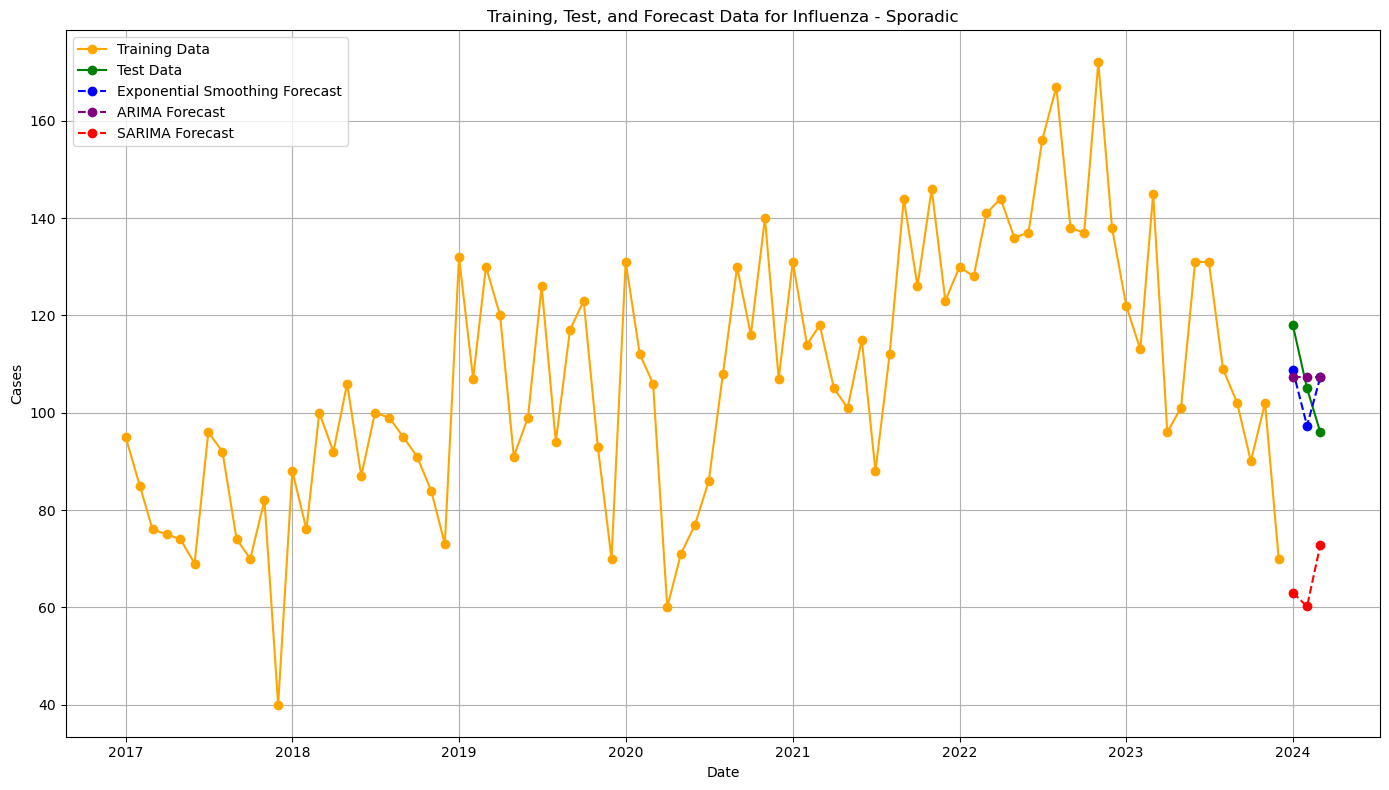

In [35]:
plt.figure(figsize=(14, 8))
plt.plot(train_data_s.index, train_data_s['Cases'], label='Training Data', color='orange', marker='o')
plt.plot(test_data_s.index, test_data_s['Cases'], label='Test Data', color='green', marker='o')
plt.plot(test_forecast_exp_smoothing_s.index, test_forecast_exp_smoothing_s, label='Exponential Smoothing Forecast', color='blue', linestyle='--', marker='o')
plt.plot(test_forecast_arima_s.index, test_forecast_arima_s, label='ARIMA Forecast', color='purple', linestyle='--', marker='o')
plt.plot(test_forecast_sarima_s.index, test_forecast_sarima_s, label='SARIMA Forecast', color='red', linestyle='--', marker='o')
plt.title('Training, Test, and Forecast Data for Influenza - Sporadic')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### The graph shows the performance of the Exponential Smoothing, ARIMA, and SARIMA models in forecasting syphilis cases. The Exponential Smoothing model (blue) aligns most closely with the test data (green), indicating its superior accuracy among the three models. ARIMA (purple) and SARIMA (red) forecasts exhibit higher deviations from the actual test data, with SARIMA showing the least accuracy. We can see in here that altthough ARIMA has the lowest RSME it didn't show any seasonality in the predictions. This visual analysis confirms the numerical evaluation, highlighting Exponential Smoothing as the most reliable model for predicting gonorrhea cases.

#

### Now that we have figured out which model performs best, we can proceed with Exponential Smoothing for forecasting the number of cases, as it best captures the time series patterns and shows the closest alignment with the test data and the lowest prediction errors compared to ARIMA and SARIMA.

In [25]:
exp_smoothing_model_full_s = ExponentialSmoothing(s_time_series.dropna(), trend='add', seasonal='add', seasonal_periods=12)
exp_smoothing_fit_full_s = exp_smoothing_model_full_s.fit()

extended_forecast_series = exp_smoothing_fit_full_s.predict(start='2024-04-01', end='2025-07-01')


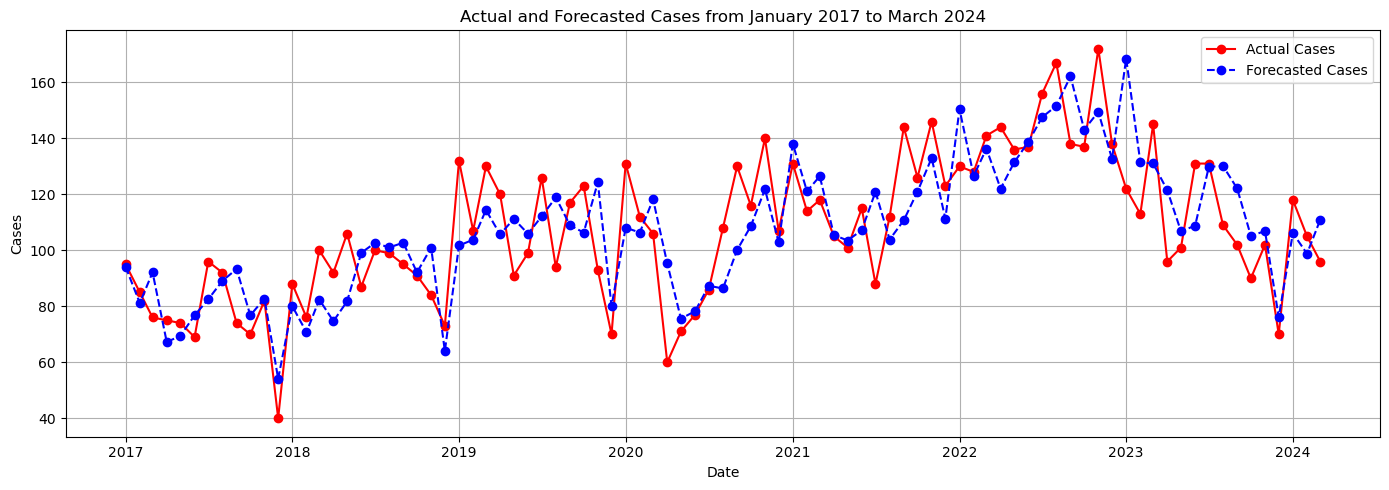

In [26]:
plt.figure(figsize=(14, 5))


plt.plot(s_time_series.index,s_time_series['Cases'], label='Actual Cases', color='red', marker='o')

plt.plot(exp_smoothing_fit_full_s.fittedvalues.index, exp_smoothing_fit_full_s.fittedvalues, label='Forecasted Cases', color='blue', linestyle='--', marker='o')

plt.title('Actual and Forecasted Cases from January 2017 to March 2024')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### The graph shows that the forecasted cases (blue) closely follow the actual cases (red) for syphilis from January 2017 to March 2024. The forecast captures the overall trend and seasonal variations, demonstrating the model's capability to predict future cases accurately. Although there are some deviations, particularly during periods of significant fluctuation, the general alignment between the forecasted and actual cases indicates the model's reliability. This consistency in prediction highlights the model's effectiveness in producing realistic forecasts that can be used for public health planning and intervention.

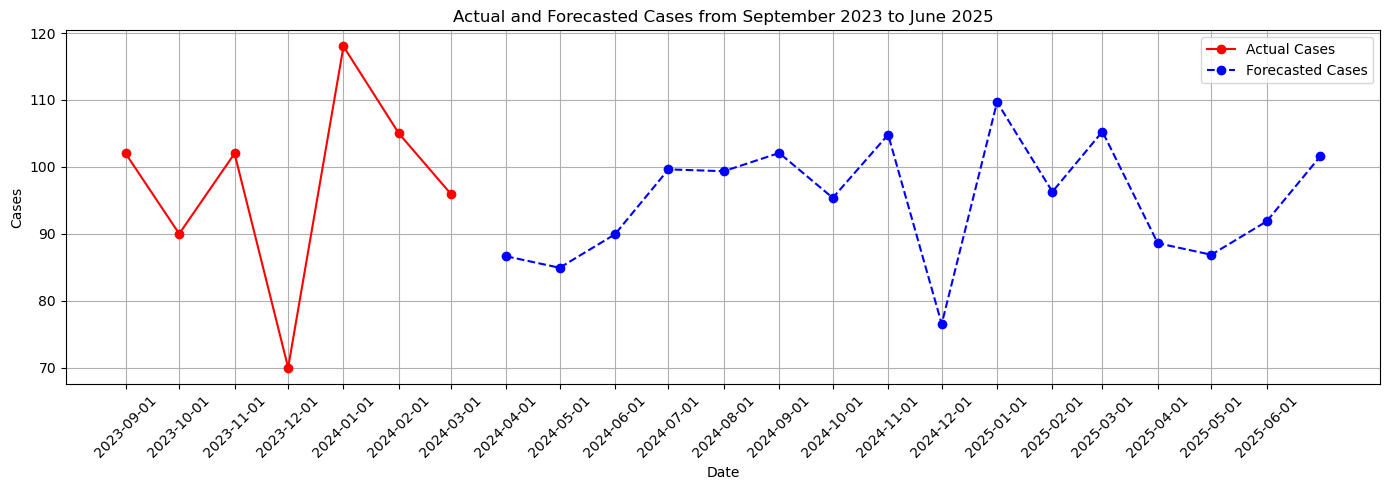

In [27]:
plt.figure(figsize=(14, 5))

actual_data_extended = s_time_series['2023-09-01':'2024-03-01']
plt.plot(actual_data_extended.index, actual_data_extended['Cases'], label='Actual Cases', color='red', marker='o')

plt.plot(extended_forecast_series.index, extended_forecast_series, label='Forecasted Cases', color='blue', linestyle='--', marker='o')

plt.xticks(pd.date_range(start='2023-09-01', end='2025-06-01', freq='MS'), rotation=45)
plt.title('Actual and Forecasted Cases from September 2023 to June 2025')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### The graph shows us that the forecasted cases (blue) capture and continue the trend observed in the actual cases (red) up to March 2024. After this period, the forecast predicts a gradual increase starting around April 2024, with notable fluctuations through mid-2025. This suggests that the model anticipates seasonal patterns and periodic increases in case numbers. The alignment between the forecasted and actual cases indicates the model's reliability in capturing the overall trend and seasonal variations in syphilis cases, providing confidence in its future predictions.

In [28]:
forecast_df = pd.DataFrame({
    'Date': extended_forecast_series.index,
    'Forecasted Cases': extended_forecast_series.values
})

forecast_df

,Date,Forecasted Cases
0,2024-04-01,86.650738
1,2024-05-01,84.925267
2,2024-06-01,89.917659
3,2024-07-01,99.629567
4,2024-08-01,99.348858
5,2024-09-01,102.075972
6,2024-10-01,95.369432
7,2024-11-01,104.815446
8,2024-12-01,76.532733
9,2025-01-01,109.666567


In [29]:
actual_data_extended

,Cases
Date,
2023-09-01,102.0
2023-10-01,90.0
2023-11-01,102.0
2023-12-01,70.0
2024-01-01,118.0
2024-02-01,105.0
2024-03-01,96.0


### The forecasted values for syphilis cases are closely aligned with the most recent actual values, demonstrating the model's reliability. For instance, the actual case number for March 2024 is 96, while the forecasted case number for April 2024 is 86.65. This close alignment between forecasted and actual data shows that the model is capable of producing realistic and reliable forecasts. Such consistency provides confidence in the model's ability to accurately predict future trends and seasonal variations in syphilis cases, making it a valuable tool for public health planning and intervention.

Rolling Forecast RMSE: 21.402228014062718


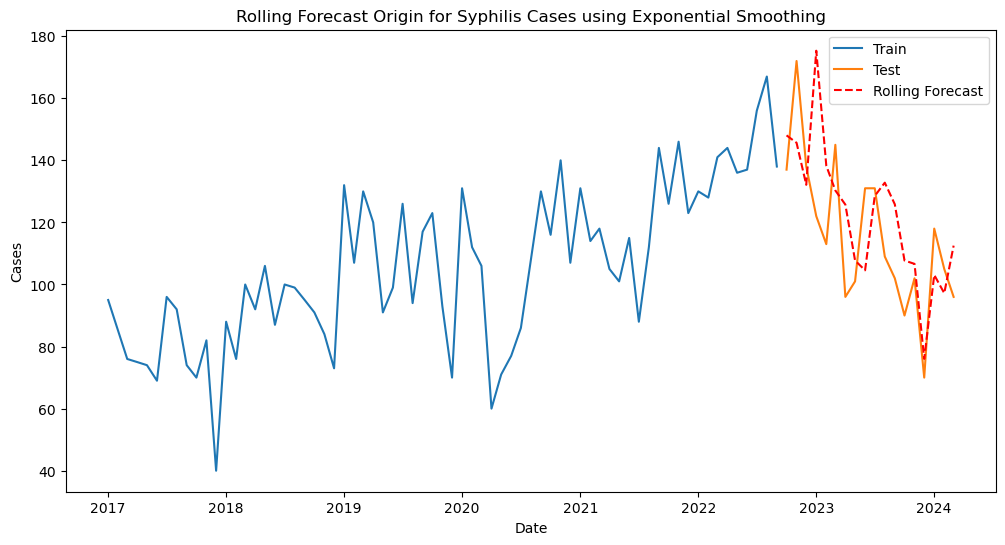

In [36]:
split_point = int(len(s_time_series) * 0.8)
train, test = s_time_series[:split_point], s_time_series[split_point:]

history = train.copy()

predictions = []
for t in range(len(test)):
    model = ExponentialSmoothing(history['Cases'], trend='mul', seasonal='add', seasonal_periods=12)
    model_fit = model.fit()
    output = model_fit.forecast(1)
    yhat = output[0]
    predictions.append(yhat)
    obs = test['Cases'].iloc[t]
    history = pd.concat([history, test.iloc[[t]]])

rmse = np.sqrt(mean_squared_error(test['Cases'], predictions))
print(f'Rolling Forecast RMSE: {rmse}')

test['Predictions'] = predictions
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Cases'], label='Train')
plt.plot(test.index, test['Cases'], label='Test')
plt.plot(test.index, test['Predictions'], label='Rolling Forecast', color='red', linestyle='--')
plt.title('Rolling Forecast Origin for Syphilis Cases using Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.show()

### The graph shows that the model's forecast for syphilis cases using Exponential Smoothing demonstrates a strong alignment with the actual data. The rolling forecast (dashed red line) follows the test data (orange line) closely, indicating that the model is capturing the overall trend and seasonal patterns effectively. The Rolling Forecast RMSE of 21.40 further supports the model's predictive accuracy. 

### Conclusion:
This model's forecast demonstrates its reliability and accuracy in predicting future trends for syphilis cases by closely aligning forecasted values with the most recent actual values. For instance, the actual case number for March 2024 is 96, while the forecasted case number for April 2024 is 86.65, indicating a close match. This consistency provides confidence in the model's capability to produce realistic and reliable forecasts. The rolling forecast validation further supports the model's effectiveness, with a rolling forecast RMSE of 21.40, indicating the model's strong predictive performance over time.

By effectively capturing these trends and accounting for significant fluctuations, the model provides realistic forecasts that can be invaluable for public health planning. Public health officials can leverage these predictions to allocate resources efficiently, anticipate potential outbreaks, and implement timely interventions. They can strengthen preventive measures during anticipated peak periods, educate the public on how to prevent contracting the disease, promote safe practices, and research the most vulnerable age groups. This proactive approach, guided by reliable forecasting, can significantly mitigate the impact of syphilis, ultimately aiming to prevent outbreaks and achieve the long-term goal of reaching 0 cases per month.